In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib
import numpy
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from scipy import stats
import datetime
num_of_tropes = 30

In [2]:
# this cell has code partially used from the PicTropes dataset preprocessing by R. H. Garcia Ortega
# - https://github.com/raiben/tropes_open_data

class TropesAndFilms(object):
    FILE_PATH = 'pictropes.txt'
    
    def __init__(self):
        self._load_data()

    def _load_data(self):
        self._init_film_dictionary()
        self._init_trope_dictionary()
        self._init_sorted_keys()
        self._init_film_by_poptrope_dictionary()
        self._init_film_by_raretrope_dictionary()

    def _init_film_dictionary(self):
        data_file_path = self._get_data_file_path()
        with open(data_file_path, 'r') as file:
            self.film_dictionary = json.load(file)

    def _get_data_file_path(self):
        script_dir = os.path.dirname('untitled.txt')
        data_file_path = os.path.join(script_dir, self.FILE_PATH)
        return data_file_path

    def _init_trope_dictionary(self):
        self.trope_dictionary = {}
        for film in self.film_dictionary.keys():
            trope_list = self.film_dictionary[film]
            for trope in trope_list:
                if trope not in self.trope_dictionary:
                    self.trope_dictionary[trope] = []
                self.trope_dictionary[trope].append(film)

    def _init_film_by_poptrope_dictionary(self):
        self.film_by_poptrope_dictionary = {}
        for trope in self.trope_dictionary.keys():
            film_list = self.trope_dictionary[trope]
            for film in film_list:
                if film not in self.film_by_poptrope_dictionary:
                    self.film_by_poptrope_dictionary[film] = []
                if len(film_list) > num_of_tropes:
                    self.film_by_poptrope_dictionary[film].append(trope)

    def _init_film_by_raretrope_dictionary(self):
        self.film_by_raretrope_dictionary = {}
        for trope in self.trope_dictionary.keys():
            film_list = self.trope_dictionary[trope]
            for film in film_list:
                if film not in self.film_by_raretrope_dictionary:
                    self.film_by_raretrope_dictionary[film] = []
                if len(film_list) <= num_of_tropes:
                    self.film_by_raretrope_dictionary[film].append(trope)
    
    def _init_sorted_keys(self):
        self.tropes_sorted_by_occurrences = sorted(self.trope_dictionary.keys(), reverse=True,
                                                   key=lambda element: len(self.trope_dictionary[element]))
        self.film_sorted_by_occurrences = sorted(self.film_dictionary.keys(), reverse=True,
                                                 key=lambda element: len(self.film_dictionary[element]))

    def tropes_dictionary_sorted_by_number_of_films(self):
        dictionary = dict()
        for trope in self.tropes_sorted_by_occurrences:
            dictionary[trope] = len(self.trope_dictionary[trope])
        return dictionary

    def films_dictionary_sorted_by_number_of_tropes(self):
        dictionary = dict()
        for film in self.film_sorted_by_occurrences:
            dictionary[film] = len(self.film_dictionary[film])
        return dictionary
    
    def films_dictionary_sorted_by_popular_tropes(self):
        dictionary = dict()
        for film in self.film_sorted_by_occurrences:
            dictionary[film] = len(self.film_by_poptrope_dictionary[film])
        return dictionary
    
    def does_film_have_trope(self, film, trope):
        tropes = self.film_by_poptrope_dictionary[film]
        return trope in tropes
    
    def films_dictionary_sorted_by_rare_tropes(self):
        dictionary = dict()
        for film in self.film_sorted_by_occurrences:
            dictionary[film] = len(self.film_by_raretrope_dictionary[film])
        return dictionary
    
    def trope_observations_by_film(self):
        return [len(values) for values in self.film_dictionary.values()]

    def film_observations_by_trope(self):
        return [len(values) for values in self.trope_dictionary.values()]
        return 0

In [3]:
# getting data from PicTropes dataset
data = TropesAndFilms()

occ = data.films_dictionary_sorted_by_number_of_tropes()
tropes = data.tropes_dictionary_sorted_by_number_of_films()
pop_tropes = data.films_dictionary_sorted_by_popular_tropes()
r_tropes = data.films_dictionary_sorted_by_rare_tropes()

# getting features such as movies, years, popular and rare tropes
movies = [i if not (i[-4:]).isnumeric() else i[:-4] for i in occ]
years = ['' if not (i[-4:]).isnumeric() else i[-4:] for i in occ]
tropes_n = [occ[i] for i in occ]
pop_tropes_n = [pop_tropes[i] for i in pop_tropes]
r_tropes_n = [r_tropes[i] for i in r_tropes]

# creating columns for dataframe
dic = {'movies' : movies, 'tropes_n' : tropes_n,'pop_tropes_n' : pop_tropes_n, 'r_tropes_n' : r_tropes_n}

# getting most popular tropes to make them all into separate features
pop_tr = [i for i in tropes if tropes[i] > num_of_tropes]

# creating features for each popular trope
for trope in pop_tr:
    lst = []
    for film, year in zip(movies,years):
        lst.append(data.does_film_have_trope(film+year, trope))
    dic[trope] = lst
    
dic['movies'] = [i.lower() for i in movies]
dt = pd.DataFrame(dic)
dt = dt.sort_values(by=['movies'])
dt['id'] = 0
dt.to_csv('new.csv')

In [4]:
# checking if there are difefrent movies with the same title
dt['movies'].is_unique

False

In [5]:
# getting data from The Movies Database
metadata = pd.read_csv('movies_metadata.csv')
# keywords = pd.read_csv('keywords.csv')
# credits = pd.read_csv('credits.csv')

#stripping titles of whitespaces and non-alphanumeric characters (except "-") and lowerspacing
metadata.original_title = metadata.original_title.apply(lambda x: ''.join(e for e in x if e.isalnum() or e == "-").lower()) 
metadata.title = metadata.title.apply(lambda x: ''.join(e for e in x if e.isalnum() or e == "-").lower() if type(x) == str else '')
movies = [''.join(e for e in i if e.isalnum() or e == "-").lower() for i in movies]

#drop duplicates if present
metadata = metadata.drop_duplicates(subset='id',keep='first')

/home/hungrynagini/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# print(metadata.id.is_unique)
# creating empty dataframe for second dataset
reduced_metadata = pd.DataFrame(columns = metadata.columns)

In [7]:
# adding the id column to first dataset using movie titles from both datasets and id's from the second one
for i in range(len(movies)):
    if movies[i] in metadata.original_title.values or movies[i] in metadata.title.values:
        if years[i]:
            ser = metadata.loc[lambda meta: meta['original_title'] == movies[i]]['release_date']
            for j in ser:
                if years[i] == j[:4]:
                    film = metadata[(metadata['release_date'] == j) & ((metadata['original_title'] == movies[i]))]
                    reduced_metadata = reduced_metadata.append(film)
                    dt.loc[dt.movies == movies[i]+years[i],'id'] = film.id.values[0]
        else:
            film = metadata[metadata['original_title'] == movies[i]]
            if film.shape != (0,24):
                reduced_metadata = reduced_metadata.append(film)
            else:
                film = metadata[metadata['title'] == movies[i]]
                reduced_metadata = reduced_metadata.append(film)
            if film.shape != (0,24):
                for idd in film.id.values:
                    if idd not in dt.id.values:
                        dt.loc[dt.movies == movies[i],'id'] = idd
                        break
                        
print(reduced_metadata.shape)

/home/hungrynagini/.local/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


(5642, 24)


In [8]:
reduced_metadata = reduced_metadata.drop_duplicates()
print(reduced_metadata.shape)

(5638, 24)


In [9]:
# merging two datasets
reduced_metadata = reduced_metadata.merge(dt,on='id')
reduced_metadata.to_csv('new_.csv')

In [10]:

def try_load(row):
    try:
        jsonparse = json.loads(row)
        return jsonparse
    except Exception as e:
        return []

# information taken from second dataset - most used production companies, countries and genres

companies = {'Orion Pictures': 35,'Fox Searchlight Pictures': 36, 'Hollywood Pictures': 36, 'Amblin Entertainment': 41,
 'Regency Enterprises': 42,'Village Roadshow Pictures': 45,'DreamWorks SKG': 46,'Canal+': 53,'Relativity Media': 
 62,'Miramax Films': 63,'Walt Disney Pictures': 69,'United Artists': 85,'TriStar Pictures': 86, 'Touchstone Pictures': 
 88,'Columbia Pictures Corporation': 100,'New Line Cinema': 107,'Columbia Pictures': 153, 'Metro-Goldwyn-Mayer (MGM)': 
 153,'Twentieth Century Fox Film Corporation': 234,'Paramount Pictures': 292, 'Universal Pictures': 296,
             'Warner Bros.': 343, 'Marvel Studios':29,  'Marvel Enterprises':29, 'Marvel Entertainment':29}

countries = {'United Kingdom': 767, 'United States of America': 4280, 'Germany': 308, 'Canada': 270, 'China': 42, 
     'Australia': 124, 'France': 337, 'New Zealand': 26, 'Czech Republic': 19, 'South Africa': 20, 'India': 23, 
     'Japan': 168, 'Italy': 154, 'Malta': 2, 'Hong Kong': 66, 'Singapore': 3, 'Indonesia': 2, 'Sweden': 36, 
     'Spain': 63, 'Mexico': 30, 'South Korea': 27, 'Hungary': 9, 'Finland': 9, 'Iceland': 7, 'Austria': 16, 
     'Brazil': 8, 'Belgium': 24, 'Bahamas': 1, 'Taiwan': 10, 'Namibia': 2, 'Serbia': 4, 'Russia': 33, 
     'Morocco': 4, 'Ireland': 38, 'Aruba': 3, 'United Arab Emirates': 7, 'Norway': 14, 'Slovenia': 1, 'Peru': 5, 
     'Romania': 9, 'Tunisia': 2, 'Slovakia': 1, 'Netherlands': 23, 'Denmark': 27, 'Thailand': 7, 'Botswana': 1, 
     'Cameroon': 1, 'Poland': 23, 'Nicaragua': 1, 'Argentina': 10, 'Israel': 11, 'Switzerland': 15, 
     'Luxembourg': 12, 'Turkey': 2, 'Cuba': 1, 'Bulgaria': 3, 'Cyprus': 1, 'Philippines': 5, 'Croatia': 3, 
     'Lithuania': 1, 'Pakistan': 2, 'Algeria': 2, 'Angola': 1, 'Greece': 4, 'Portugal': 4, 'Uruguay': 2, 
     'Malaysia': 1, 'Yugoslavia': 1, 'Soviet Union': 1, 'Paraguay': 1, 'Trinidad and Tobago': 1, 'Iran': 3, 
     'Chile': 2, 'Bosnia and Herzegovina': 1, 'Puerto Rico': 2, 'Kazakhstan': 1, 'Georgia': 2, 'North Korea': 1, 
     'Czechoslovakia': 1, 'Afghanistan': 1, 'Estonia': 1, 'Ecuador': 1, 'Monaco': 1, 'Liechtenstein': 1}

genres = ['Animation', 'Comedy', 'Family', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 
          'Thriller', 'Horror', 'History', 'Science Fiction', 'Mystery', 'War', 'Foreign', 'Music', 
          'Documentary', 'Western', 'TV Movie']

In [11]:
reduced_metadata.belongs_to_collection = metadata.belongs_to_collection.apply(lambda x: 1 if type(x) != float else 0)

cmp = reduced_metadata.apply(lambda x: [i['name']
                          for i in try_load(x.production_companies.replace("'","\""))] if 
                                                         len(x) > 2 and type(x) != float else 0,axis=1)

reduced_metadata = reduced_metadata.assign(prod_cmp=cmp.values)

for i in companies.keys():
    reduced_metadata[i] = reduced_metadata.apply(lambda x: 1
                          if i in x.prod_cmp and len(x) > 0 and type(x) != float else 0,axis=1)
#     reduced_metadata = reduced_metadata.assign(i=i_.values)

reduced_metadata = reduced_metadata.drop(["prod_cmp"],axis=1)

col = reduced_metadata.apply(lambda x: 1 if sum([1 if countries[i['name']] < 40 else 0 for i in 
     json.loads(x.production_countries.replace("'","\""))]) and len(x) > 2 and type(x) != float else 0, axis=1)
col2 = reduced_metadata.apply(lambda x: 1 if {"iso_3166_1": "US", "name": "United States of America"}
    in json.loads(x.production_countries.replace("'","\"")) and len(x) > 2 and type(x) != float else 0,axis=1)
col3 = reduced_metadata.apply(lambda x: sum([countries[i['name']] 
  for i in json.loads(x.production_countries.replace("'","\""))]) if len(x) > 2 and type(x) != float else 0,axis=1)
reduced_metadata = reduced_metadata.assign(countries_rare=col.values,countries_usa=col2.values,
                                           countries_points_sum=col3.values )

In [12]:
reduced_metadata['Warner Bros.']

0       0
1       1
2       0
3       0
4       1
       ..
4883    0
4884    0
4885    0
4886    0
4887    0
Name: Warner Bros., Length: 4888, dtype: int64

In [13]:
# reduced_metadata.genres = metadata.genres.apply(lambda x: [i['name'] 
#                           for i in json.loads(x.replace("'","\""))] if len(x) > 2 and type(x) != float else 0) 

for i in genres:
    reduced_metadata[i] = metadata.genres.apply(lambda x: 1 if i in x and type(x) != float else 0) 
    
features = reduced_metadata.drop(['id','original_language','tagline','overview','status','production_companies',
                                  'spoken_languages','production_countries','adult','movies','video',
                                  "homepage",'imdb_id','original_title','title','poster_path','genres'],axis=1)
features = features.dropna()
features['date'] = pd.to_datetime(features['release_date'])
features['date']=features['date'].map(datetime.datetime.toordinal)
features['month_day'] = features['release_date'].apply(lambda x: int(x[-5:-3]+x[-2:]))
features = features.drop(["release_date"],axis=1)
features.date

0       735444
1       734700
2       734340
3       734248
4       733764
         ...  
4883    734491
4884    734179
4885    733408
4886    722227
4887    733812
Name: date, Length: 4887, dtype: int64

In [17]:
from sklearn.impute import SimpleImputer

numeric_imputer = SimpleImputer(missing_values = 0, strategy = 'mean')
features[['budget', 'revenue']] = numeric_imputer.fit_transform(features[['budget', 'revenue']])

features['gross_revenue'] = features['revenue'] - features['budget']
roi = features.gross_revenue.astype('float')/features.budget.astype('float')
features['roi'] = roi
rating = features.vote_average.astype('float')
popularity = features.popularity.astype('float')
revenue = features.revenue.astype('float')
features = features.rename(columns={'ComicBookMoviesDontUseCodenames':"CBMDUC",'WhatHappenedToTheMouse':"WHTTM"})

feat_rat = ['date','budget','popularity','runtime','vote_average', 'month_day', 'Comedy','Adventure', 'Family',
'pop_tropes_n','r_tropes_n', 'countries_points_sum','tropes_n', 'countries_usa', 'roi',
'Drama', 'Crime', 'Thriller','ShoutOut','vote_count', 'BittersweetEnding','CBMDUC']

# feat_rat = ['date','budget','popularity','runtime','vote_average', 'month_day', 'Comedy', 'Adventure', 'Family',
# 'pop_tropes_n','r_tropes_n', 'countries_points_sum','tropes_n', 'countries_usa', 'roi','DownerEnding',
# 'Drama', 'Crime', 'Thriller','ShoutOut','vote_count', 'BittersweetEnding','DeadpanSnarker','Warner Bros.']

feat_pop = ['date','belongs_to_collection','budget','popularity','revenue','runtime','vote_average',
'pop_tropes_n','r_tropes_n', 'Comedy','countries_points_sum','tropes_n', 'Marvel Studios',
'Romance', 'Drama', 'Action', 'Thriller','ManlyTears','CBMDUC','roi', 'Warner Bros.','TheAtoner',
            'ShoutOut','month_day','BigBad','BittersweetEnding','Foreshadowing','TechnologyPorn']

feat_rev = ['date','belongs_to_collection','budget','popularity','revenue','runtime','vote_average','roi',
'pop_tropes_n','r_tropes_n', 'Comedy', 'Family', 'Adventure','countries_points_sum','tropes_n','MythologyGag',
'Romance', 'Drama', 'Action', 'Crime', 'Thriller','BittersweetEnding','ShoutOut','month_day','Foreshadowing','revenue']

pop_feat = features[feat_pop]
rev_feat = features[feat_rev]
rat_feat = features[feat_rat]

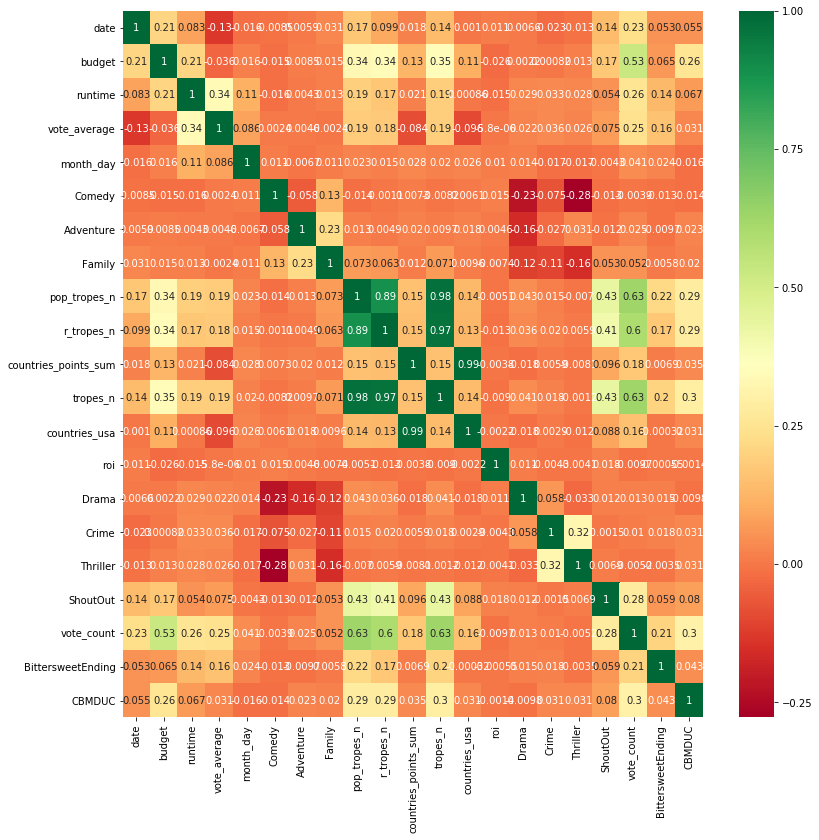

In [18]:
import matplotlib.cm as cm
from matplotlib import pyplot as plt

import numpy as np
import seaborn as sns
#get correlations of each feature
# for i in [pop_feat, rat_feat, rev_feat]:
i = rat_feat
corrmat = i.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(13,13))
#plot heat map
g=sns.heatmap(i[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [19]:
# feature importance on decreased feature set for Linear Regression

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
classifier = LogisticRegression(fit_intercept=False,multi_class='auto',solver='lbfgs')
selector = RFE(classifier,n_features_to_select=1)

popularity = popularity.apply(lambda x: 0 if x < 60 else 1 if x < 120 else 2)
revenue = revenue.apply(lambda x: 0 if x < 0.9 else 1 if x < 2.2 else 2)
rating = pd.cut(rating, bins=10, labels=np.arange(10), right=False)

def sortfirst(val): 
    return int(val[0]) if val[1] == ',' else int(val[0:2])

for i in [[pop_feat, rev_feat, rat_feat]]:
    
    x_for_popularity = i[0].drop(['popularity','revenue'],axis=1)
    x_for_revenue = i[1].drop(['revenue','popularity'],axis=1)
    x_for_rating = i[2].drop(['vote_average'],axis=1)

    for x,y,z,bins_ in zip([x_for_popularity, x_for_revenue, x_for_rating],[popularity, revenue, rating], 
                 ['popularity', 'revenue', 'rating'],[20,15,10]):
#         y = pd.cut(y, bins=bins_, labels=np.arange(bins_), right=False)
        selector.fit(x,y)
        order = selector.ranking_
        f_r = []
        print(order)
        for i in range(len(order)):
            f_r.append(f"{order[i]},{x.columns[i]}")
        f_r.sort(key=sortfirst)
        for i in f_r:
            print(i)

[ 3 24  4  6 10  8  9 12  2  7 21 19 11 16 14 26 23  1 20 17 18  5 15 13
 25 22]
1,roi
2,countries_points_sum
3,date
4,budget
5,month_day
6,runtime
7,tropes_n
8,pop_tropes_n
9,r_tropes_n
10,vote_average
11,Drama
12,Comedy
13,BittersweetEnding
14,Thriller
15,BigBad
16,Action
17,TheAtoner
18,ShoutOut
19,Romance
20,Warner Bros.
21,Marvel Studios
22,TechnologyPorn
23,CBMDUC
24,belongs_to_collection
25,Foreshadowing
26,ManlyTears
[ 1 21  7  5 10  2  8  9 12 19 16  3  6 23 14 11 20 15 17 18 13  4 22]
1,date
2,roi
3,countries_points_sum
4,month_day
5,runtime
6,tropes_n
7,budget
8,pop_tropes_n
9,r_tropes_n
10,vote_average
11,Drama
12,Comedy
13,ShoutOut
14,Romance
15,Crime
16,Adventure
17,Thriller
18,BittersweetEnding
19,Family
20,Action
21,belongs_to_collection
22,Foreshadowing
23,MythologyGag


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase t

[ 2  3 11  7  6 14 19 20  9 10  4  8 12  1 13 18 17 16  5 15 21]
1,roi
2,date
3,budget
4,countries_points_sum
5,vote_count
6,month_day
7,runtime
8,tropes_n
9,pop_tropes_n
10,r_tropes_n
11,popularity
12,countries_usa
13,Drama
14,Comedy
15,BittersweetEnding
16,ShoutOut
17,Thriller
18,Crime
19,Adventure
20,Family
21,CBMDUC


decision tree
[0.         0.         0.         ... 0.         0.20922468 0.        ]


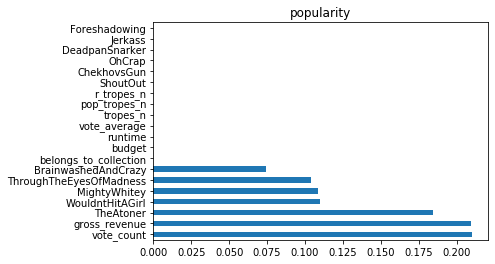

decision tree
[0.         0.         0.         ... 0.         0.         0.49979529]


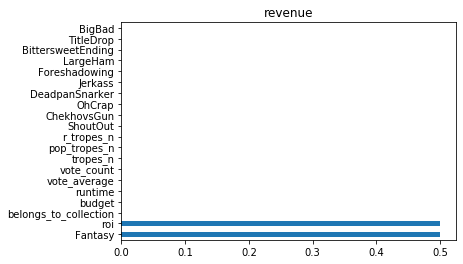

decision tree
[0.00585935 0.03347809 0.038394   ... 0.03463184 0.0176707  0.01265456]


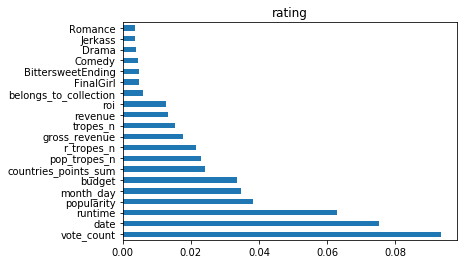

decision tree
[0.16296521 0.         0.1017192  0.08344907 0.05709733 0.02575589
 0.05729536 0.         0.05394687 0.14251904 0.         0.
 0.         0.         0.         0.         0.         0.18544238
 0.         0.         0.         0.07417695 0.         0.05563271
 0.         0.        ]


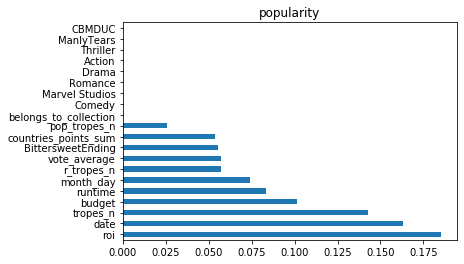

decision tree
[0.         0.         0.         0.         0.         0.49979529
 0.50020471 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]


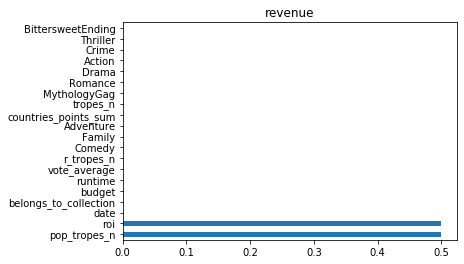

decision tree
[0.13176187 0.06481557 0.08711528 0.11538516 0.09824847 0.0087531
 0.00797344 0.00599436 0.05537936 0.05642837 0.0492059  0.05484548
 0.00450438 0.0594379  0.01101622 0.0086161  0.00916988 0.00956324
 0.15273069 0.00905526 0.        ]


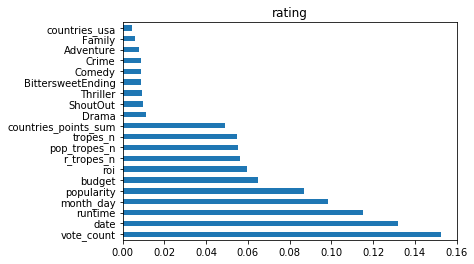

/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


extra trees
[0.00841724 0.00113038 0.02087235 ... 0.00556327 0.02908605 0.        ]


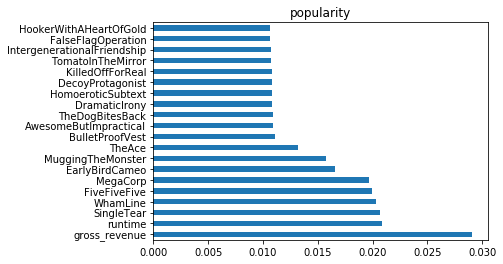

extra trees
[0.         0.         0.01667349 ... 0.         0.         0.        ]


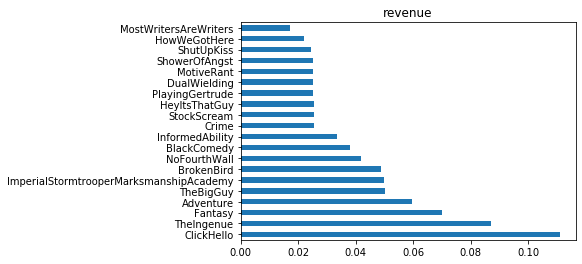

extra trees
[0.0039159  0.00578    0.00916743 ... 0.00805567 0.00637968 0.00538141]


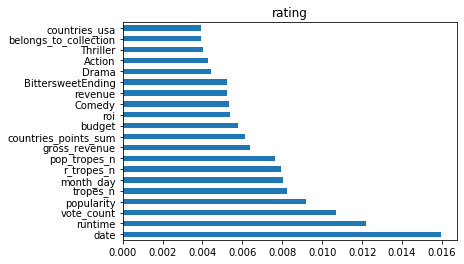

extra trees
[0.02520838 0.02555988 0.07227656 0.05902531 0.10118309 0.06948852
 0.05852989 0.02821013 0.04577886 0.08150655 0.02648356 0.04048226
 0.00984431 0.01427079 0.01524231 0.00250031 0.00534921 0.06277235
 0.0271999  0.02348464 0.04177385 0.05120976 0.01804265 0.05314433
 0.03364402 0.00778858]


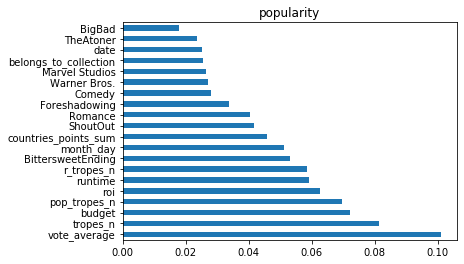

extra trees
[3.53806623e-02 2.35560864e-02 6.94535119e-02 5.48925946e-02
 6.65974810e-02 1.24636298e-01 1.32165975e-01 1.05882695e-01
 1.31693872e-02 2.63586784e-02 2.19032963e-02 1.79240948e-04
 7.70164132e-02 9.77938480e-05 2.64490133e-02 1.99229949e-02
 5.10465375e-02 6.66939611e-03 3.90987668e-03 3.92933270e-04
 9.77631897e-03 1.29590831e-01 9.51984823e-04]


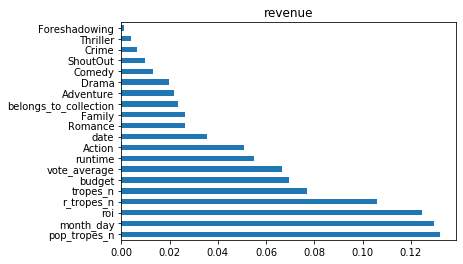

extra trees
[0.10187941 0.06066396 0.08717847 0.09217407 0.0782699  0.02623763
 0.01487045 0.0159776  0.07322869 0.0740557  0.04966128 0.07089364
 0.00768186 0.05793632 0.03127793 0.01979502 0.01862925 0.01256272
 0.09564664 0.0109069  0.00047256]


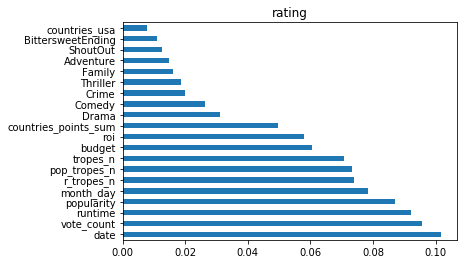

/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


random forest
[0.         0.01265475 0.01708763 ... 0.         0.         0.        ]


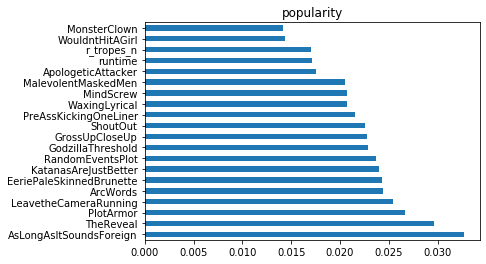

random forest
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.23742955e-04
 2.12885502e-01 0.00000000e+00]


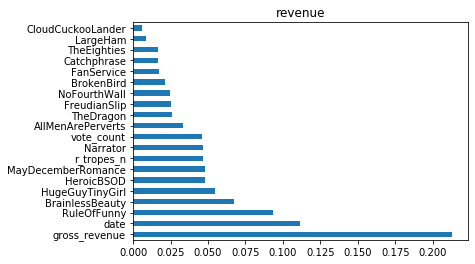

random forest
[0.00376407 0.01554371 0.0256963  ... 0.01869028 0.01533972 0.01359396]


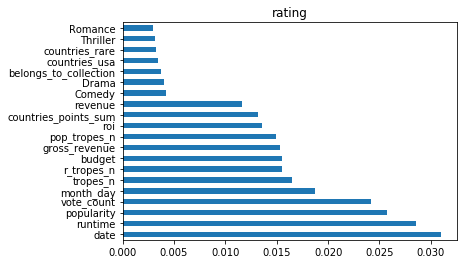

random forest
[0.18811456 0.         0.15050835 0.03587406 0.11296403 0.1193818
 0.04722429 0.         0.04968707 0.08149323 0.00357615 0.00357917
 0.01858968 0.01289695 0.00778383 0.         0.         0.04176399
 0.02097187 0.02019339 0.0398198  0.01976504 0.01169436 0.0105392
 0.00357917 0.        ]


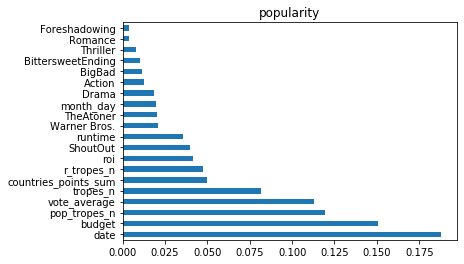

random forest
[1.09397385e-01 4.68639628e-02 0.00000000e+00 7.20929377e-05
 4.07686496e-02 7.36965394e-01 0.00000000e+00 4.16837257e-02
 0.00000000e+00 0.00000000e+00 3.77080383e-04 0.00000000e+00
 9.45896165e-03 0.00000000e+00 0.00000000e+00 1.38927845e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.19962791e-04 0.00000000e+00]


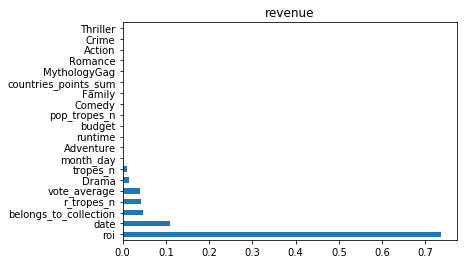

random forest
[0.11829349 0.05631869 0.09495673 0.10658055 0.08613241 0.01703732
 0.01077258 0.00892512 0.06718444 0.0667415  0.04319993 0.07228046
 0.00986874 0.06445712 0.01610151 0.01029838 0.01317618 0.01077547
 0.11674356 0.00972917 0.00042664]


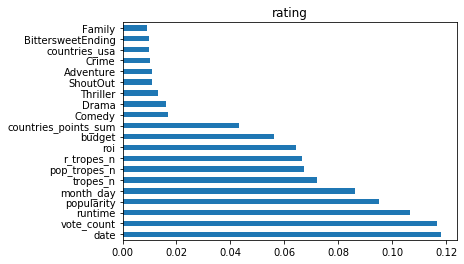

In [20]:
# feature importance on whole feature set and decreased for other classifiers
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import matplotlib.pyplot as plt

for model in [[tree.DecisionTreeClassifier(),'decision tree'],[ExtraTreesClassifier(),'extra trees'],
              [RandomForestClassifier(),'random forest']]:
    for i in [[features,features,features],[pop_feat, rev_feat, rat_feat]]:
        x_for_popularity = i[0].drop(['popularity','revenue'],axis=1)
        x_for_revenue = i[1].drop(['revenue','popularity'],axis=1)
        x_for_rating = i[2].drop(['vote_average'],axis=1)

        for x,y,z,bins_ in zip([x_for_popularity, x_for_revenue, x_for_rating],[popularity, revenue, rating], 
                     ['popularity', 'revenue', 'rating'],[20,15,10]):
    #         y = pd.cut(y, bins=bins_, labels=np.arange(bins_), right=False)
            model[0].fit(x,y)
            print(model[1])
            print(model[0].feature_importances_)
            feat_importances = pd.Series(model[0].feature_importances_, index=x.columns)
            feat_importances.nlargest(20).plot(kind='barh')
            plt.title(z)
            plt.show()

In [21]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

model = LogisticRegression(solver='lbfgs')

for i,what in zip([[features,features,features],[pop_feat, rev_feat, rat_feat]],
                  ['features including tropes','features without separate tropes']):
    print(what)
    x_for_popularity = i[0].drop(['popularity','revenue'],axis=1)
    x_for_revenue = i[1].drop(['revenue','popularity'],axis=1)
    x_for_rating = i[2].drop(['vote_average'],axis=1)
    for x,y in zip([x_for_popularity, x_for_revenue, x_for_rating],[popularity, revenue, rating]):
#         print(pd.cut(y,bins= bins_))
        x = RobustScaler().fit_transform(x)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        model.fit(x_train, y_train)

        acc_trained = model.score(x_train, y_train)
        print("Training accuracy: {}".format(acc_trained))

        predicted = model.predict(x_test)
        print(model.score(x_test,y_test))
        acc_test = accuracy_score(y_test, predicted)
        print("Testing accuracy:  {}\n".format(acc_test))

        f_score = f1_score(y_test, predicted, average='micro')
        print("f1:", f_score)
        print('Confusion Matrix - Training Dataset')
        print(pd.crosstab(y_test, predicted, rownames = ['True'], colnames = ['Predicted'], margins = True))
        print("\n",cross_val_score(LogisticRegression(), x, y, cv=3))
        

features including tropes


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: De

Training accuracy: 1.0
0.9969001859888407
Testing accuracy:  0.9969001859888407

f1: 0.9969001859888407
Confusion Matrix - Training Dataset
Predicted     0   All
True                 
0          1608  1608
1             3     3
2             2     2
All        1613  1613


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)



 [0.92699387 0.99815838 0.9987715 ]


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training accuracy: 1.0
1.0
Testing accuracy:  1.0

f1: 1.0
Confusion Matrix - Training Dataset
Predicted     2   All
True                 
2          1613  1613
All        1613  1613


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



 [0.99325153 0.99938613 1.        ]


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarnin

Training accuracy: 0.30849114233353697
0.3050216986980781
Testing accuracy:  0.3050216986980781

f1: 0.3050216986980781
Confusion Matrix - Training Dataset
Predicted  2  4    5    6     7    8   All
True                                      
0          0  0    1    1     2    0     4
1          0  0    1    2     3    1     7
2          0  0    4    1    11    2    18
3          0  0    1    2    10    0    13
4          0  0   17   14    44   10    85
5          0  0   49   16   149   37   251
6          0  1   29   52   442  109   633
7          1  0    3   32   378   66   480
8          0  0    0   10    97   13   120
9          0  0    0    0     2    0     2
All        1  1  105  130  1138  238  1613


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureW


 [0.28142244 0.43830571 0.414874  ]
features without separate tropes


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Training accuracy: 0.9990836896762371
0.9969001859888407
Testing accuracy:  0.9969001859888407

f1: 0.9969001859888407
Confusion Matrix - Training Dataset
Predicted     0   All
True                 
0          1608  1608
1             3     3
2             2     2
All        1613  1613


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/


 [0.85276074 0.99815838 0.9987715 ]
Training accuracy: 0.9993891264508247
1.0
Testing accuracy:  1.0

f1: 1.0
Confusion Matrix - Training Dataset


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/li

Predicted     2   All
True                 
2          1613  1613
All        1613  1613

 [0.94785276 0.99938613 1.        ]


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarnin

Training accuracy: 0.27367135003054366
0.2851828890266584
Testing accuracy:  0.2851828890266584

f1: 0.2851828890266584
Confusion Matrix - Training Dataset
Predicted    4  5    6     7  9   All
True                                 
0            0  1    1     2  0     4
1            1  0    1     5  0     7
2            5  0    4     9  0    18
3            2  0    2     9  0    13
4           20  1   20    44  0    85
5           58  6   35   152  0   251
6          140  0   69   424  0   633
7           79  1   35   364  1   480
8           15  0    8    97  0   120
9            0  0    0     1  1     2
All        320  9  175  1107  2  1613


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureW


 [0.24524831 0.46838551 0.37922557]


In [ ]:
from sklearn.svm import SVC
model = SVC(gamma='auto',kernel='linear')
# clf.fit(X, y)
# clf.predict()
for i,what in zip([[pop_feat, rev_feat, rat_feat]],
                  ['features without separate tropes']):
    print(what)
    x_for_popularity = i[0].drop(['popularity','revenue'],axis=1)
    x_for_revenue = i[1].drop(['revenue','popularity'],axis=1)
    x_for_rating = i[2].drop(['vote_average'],axis=1)
    for x,y in zip([x_for_popularity, x_for_revenue, x_for_rating],[popularity, revenue, rating]):
#         print(pd.cut(y,bins= bins_))
        x = RobustScaler().fit_transform(x)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        model.fit(x_train, y_train)

        acc_trained = model.score(x_train, y_train)
        print("Training accuracy: {}".format(acc_trained))

        predicted = model.predict(x_test)

        acc_test = accuracy_score(y_test, predicted)
        print("Testing accuracy:  {}\n".format(acc_test))

        f_score = f1_score(y_test, predicted, average='micro')
        print("f1:", f_score)
        print('Confusion Matrix - Training Dataset')
        print(pd.crosstab(y_test, predicted, rownames = ['True'], colnames = ['Predicted'], margins = True))
        print("\n",cross_val_score(SVC(gamma='auto'), x, y, cv=3))
        

features without separate tropes
Training accuracy: 1.0
Testing accuracy:  0.9956602603843769

f1: 0.9956602603843769
Confusion Matrix - Training Dataset
Predicted     0  2   All
True                    
0          1606  2  1608
1             3  0     3
2             2  0     2
All        1611  2  1613

 [0.99754601 0.99815838 0.9987715 ]
Training accuracy: 0.9993891264508247
Testing accuracy:  1.0

f1: 1.0
Confusion Matrix - Training Dataset
Predicted     2   All
True                 
2          1613  1613
All        1613  1613

 [0.9993865  0.99938613 1.        ]


/home/hungrynagini/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


In [ ]:
from sklearn import tree
# model = RandomForestClassifier()
# model = tree.DecisionTreeClassifier()
model = ExtraTreesClassifier(n_estimators=100, random_state=1)

for i,what in zip([[features,features,features],[pop_feat, rev_feat, rat_feat]],
                  ['features including tropes','features without separate tropes']):
    print(what)
    x_for_popularity = i[0].drop(['popularity','revenue'],axis=1)
    x_for_revenue = i[1].drop(['revenue','popularity'],axis=1)
    x_for_rating = i[2].drop(['vote_average'],axis=1)
    for x,y in zip([x_for_popularity, x_for_revenue, x_for_rating],[popularity, revenue, rating]):
#         print(pd.cut(y,bins= bins_))
        x = RobustScaler().fit_transform(x)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
        model.fit(x_train, y_train)

        acc_trained = model.score(x_train, y_train)
        print("Training accuracy: {}".format(acc_trained))

        predicted = model.predict(x_test)

        acc_test = accuracy_score(y_test, predicted)
        print("Testing accuracy:  {}\n".format(acc_test))

        f_score = f1_score(y_test, predicted, average='micro')
        print("f1:", f_score)
        print('Confusion Matrix - Training Dataset')
        print(pd.crosstab(y_test, predicted, rownames = ['True'], colnames = ['Predicted'], margins = True))
        print("\n",cross_val_score(LogisticRegression(), x, y, cv=3))